# A* Search

We will be trying to find and visualize the path between Equestrian Statue of Edward VII and Bahen Center of Technology around Toronto University campus using A* search


__DIJKSTRA-SEARCH__(graph) __returns__ a route and cost, or failure  
&emsp;__if__ _graph_ first node is a goal __then return__ empty path to initial state  
&emsp;_frontier_ &larr; a **Priority** queue, prioritizes **sum** of distance **to the destination *and* origin node**,initially containing one path, for the _graph_'s initial node  
&emsp;_reached_ &larr; a set of states; initially empty  
&emsp;_solution_ &larr; failure  
&emsp;__while__  _frontier_ is not empty __do__  
&emsp;&emsp;&emsp;_parent_ &larr; the first node in _frontier_  
&emsp;&emsp;&emsp;__for__ _child_ __in__ successors(_parent_) __do__   
&emsp;&emsp;&emsp;&emsp;&emsp;_s_ &larr; _child_.state  
&emsp;&emsp;&emsp;&emsp;&emsp;__if__ _s_ is a goal  __then__  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;__return__  _child_  
&emsp;&emsp;&emsp;&emsp;&emsp;__if__ _s_ is not in _reached_ __then__  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;add _s_ to _reached_  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;add _child_ to the end of _frontier_  
&emsp;__return__  _solution_

In [ ]:
%%capture

##############################################################################
# IGNORE if you are running on a local machine and have all the dependencies #
##############################################################################

# installing dependencies --- to be able to run on google colab
# it would take 2-3 minutes
!apt-get install libspatialindex-c4v5;
!pip3 install Rtree;
!pip3 install osmnx;
!pip3 install tqdm;

# you HAVE to upload a number of files and folders used in the code
# problem.py - utils.py - data files inside directory named data
# upload them in the home directory --- don't go into any folder, just press upload button
# and choose these files and folders
# so tthe directory should be 
#|- data/       |- graph.html
#|              |- route.html 
#|- sample_data/ 
#|- problem.py
#|- utils.py

In [1]:
import osmnx as ox
import networkx as nx
from tqdm import tqdm
import time
from IPython.display import IFrame, HTML
from collections import deque
import matplotlib.pyplot as plt
from problem import *
from utils import *

Here OSMnx returns the largest connected component centered around the ```location point``` with specified ```dist``` on each side (w/n/e/s).

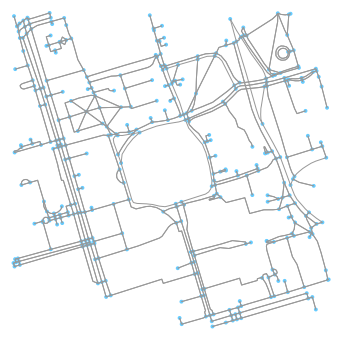

In [2]:
location_point = (43.661667, -79.395)
G = ox.graph_from_point(location_point, dist=300, clean_periphery=True, simplify=True)
graph_map = ox.plot_graph_folium(G, popup_attribute='name', edge_width=2)
fig, ax = ox.plot_graph(G)

In [3]:
# we need to save the graph 
filepath = 'data/graph.html'
graph_map.save(filepath)
IFrame(filepath, width=600, height=500)

Here you need to specify which node from our graph is the source (Equestrian Statue of Edward VII) and which is the destination node (Bahen Center of Technology). You can do so by acquiring the decimal coordinates of the desired node and use [```osmnx.distance.get_nearest_node```](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.distance.get_nearest_node) method

I used the aforementioned method and found that the nodes for destination and source are 389677909, 55808290 respectively

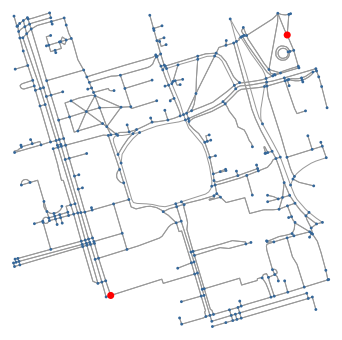

In [4]:
# marking both the source and destination node

nc = ['r' if node == 389677909 or node == 55808290 else '#336699' for node in G.nodes()]
ns = [50 if node == 389677909 or node == 55808290 else 8 for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_size=ns, node_color=nc, node_zorder=2)

Each node in our graph is represented as a dictionary so manipulating them would obfuscate the algorithm manipulating them and would be unnecessary expensive computationally <b>so</b> we define class ```Node``` only retains the data we need to be able to do searching and traversing.

Please check its source code in ```./problem.py``` to know how it capture the data from the graph or just remove ```%%capture``` to check the source code in here

In [5]:
%%capture
source(Node)

# The Algorithm

In [6]:
# first define the origin/source nodes as Node
origin = Node(graph = G, node = G[55808290], osmid = 55808290, distance = 0, parent = None)
destination = Node(graph = G, node = G[389677909], osmid = 389677909)

## The Heuristic

What drives node expansion in A* algorithm is determining the closet node to both the origin and destination by summing these both distances so what we need here is a function that returns a data structure that associates with each node that metric

In [7]:
toGoal, toDestination = Astar_distance(G, 55808290, 389677909)

Now we need to have a kind of priority queue like we did in ```dijkstra``` algorithm but we can't relay on Python standard libraries here because ```toGoal``` and ```toDestination``` metrics are not from ```Node``` attributes

What we will do here is have a typical minimum heap for our nodes with a lambda function define the heapify-ing metric which is the summation of the ```toDestination``` and ```toGoal``` distances

In [8]:
frontier = PriorityQueue('min', lambda node: toGoal[node.osmid] + toDestination[node.osmid])

route = []
bar = tqdm(total=len(G))

frontier.append(origin)
explored = set()
found = False
while frontier and not found:
    bar.update(1); time.sleep(0.1)
    node = frontier.pop()
    explored.add(node)
    if node == destination:
        route, cost = node.path()
        found = True
        continue
    for child in node.expand():
        if child not in explored and child not in frontier:
            if child == destination:
                route, cost = child.path()
                found = True
                continue
            frontier.append(child)
bar.close()
print(route)

 24%|██▍       | 90/375 [00:09<00:29,  9.77it/s]

[55808290, 304891685, 55808284, 1252869817, 55808239, 389678268, 4953810915, 389678267, 24960090, 389678273, 1258698113, 389678151, 389678142, 2143489694, 389678141, 2143488528, 389678140, 389678139, 389678138, 3707407638, 6028561924, 6028561921, 389678131, 6028562356, 389677908, 749952029, 389677909]


the length of the route is

In [9]:
cost

838.9289999999999

let's visualize that route

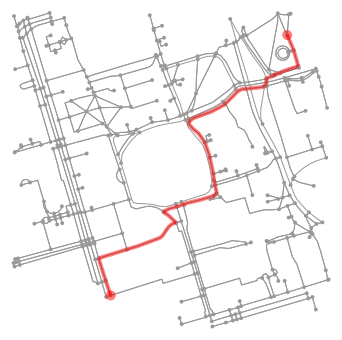

In [10]:
fig, ax = ox.plot_graph_route(G, route)

Open this and dijkstra'route and look the difference and how the heuristic of A star change the trend of traversing

It starts the same the first few nodes, but as you can see it the A star heuristic really in action at step 4-5 where the to-be-expanded nodes looks closer to the goal and destination than the others

In [11]:
route_map = ox.plot_route_folium(G, route)
filepath = 'data/route.html'
route_map.save(filepath)
IFrame(filepath, width=600, height=500)